# Data Analysis and Visualization for HPC Benchmarking Results

All visualizations are created and saved in the [`benchmark_plots`](https://github.com/ThongLai/Cluster-and-Cloud-Benchmarking/tree/main/benchmark_plots) directory.

In [1]:
import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

Python Version: `3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python312`
Current Environment location: `Python312`



In [2]:
# %pip install pandas matplotlib seaborn numpy

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up data

In [4]:
# Set plotting style
plt.style.use('ggplot')
sns.set_palette("colorblind")

# Create output directory for plots
os.makedirs('benchmark_plots', exist_ok=True)

def read_pingpong_file(filename):
    return pd.read_csv(f"data_results/{filename}")

def read_matmat_file(filename):
    return pd.read_csv(f"data_results/{filename}")

# Load pingpong data
pingpong_files = {
    # My VM files
    'my_p2_s1': 'pingpong_p2_s1.csv',
    'my_p2_s2': 'pingpong_p2_s2.csv',
    'my_p4_s2': 'pingpong_p4_s2.csv',
    # Hatim's VM files
    'hatim_p2_s1': 'pingpong_p2_s1_vm2.csv',
    'hatim_p2_s2': 'pingpong_p2_s2_vm2.csv',
    'hatim_p4_s2': 'pingpong_p4_s2_vm2.csv'
}

# Load matrix multiplication data
matmat_files = {
    # My VM files
    'my_p2_s1': 'mat_mat_p2_s1.csv',
    'my_p2_s2': 'mat_mat_p2_s2.csv',
    'my_p4_s2': 'mat_mat_p4_s2.csv',
    # Hatim's VM files
    'hatim_p2_s1': 'mat_mat_p2_s1_vm2.csv',
    'hatim_p2_s2': 'mat_mat_p2_s2_vm2.csv',
    'hatim_p4_s2': 'mat_mat_p4_s2_vm2.csv'
}

pingpong_data = {key: read_pingpong_file(filename) for key, filename in pingpong_files.items()}

matmat_data = {key: read_matmat_file(filename) for key, filename in matmat_files.items()}

# ===== PINGPONG LATENCY/BANDWIDTH COMPARISON =====

Shows how message latency/bandwidth varies with message size between both VMs

In [5]:
def plot_pingpong_comparison(config='p2_s1', metric='Latency'):
    if metric not in ['Latency', 'Bandwidth']:
        raise ValueError("metric must be either 'Latency' or 'Bandwidth'")
    
    config_labels = {
        'p2_s1': '2 proc/1 slot',
        'p2_s2': '2 proc/2 slots',
        'p4_s2': '4 proc/2 slots'
    }
    
    metric_config = {
        'Latency': {
            'column': 'Latency (us)',
            'ylabel': 'Latency (µs)',
            'title_suffix': '(Lower is Better)'
        },
        'Bandwidth': {
            'column': 'Bandwidth (MiB/s)',
            'ylabel': 'Bandwidth (MiB/s)',
            'title_suffix': '(Higher is Better)'
        }
    }
    
    plt.figure(figsize=(12, 7))
    
    # Plot my VM data
    plt.loglog(pingpong_data[f'my_{config}']['Message Size (bytes)'], 
              pingpong_data[f'my_{config}'][metric_config[metric]['column']], 
              'o-', label=f'My VM ({config_labels[config]})', linewidth=2)
    
    # Plot Hatim's VM data
    plt.loglog(pingpong_data[f'hatim_{config}']['Message Size (bytes)'], 
              pingpong_data[f'hatim_{config}'][metric_config[metric]['column']], 
              's-', label=f'Hatim\'s VM ({config_labels[config]})', linewidth=2)
    
    plt.xlabel('Message Size (bytes)', fontsize=12)
    plt.ylabel(metric_config[metric]['ylabel'], fontsize=12)
    plt.title(f'Pingpong {metric} Comparison - {config_labels[config]} {metric_config[metric]["title_suffix"]}', 
             fontsize=14, fontweight='bold')
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(f'benchmark_plots/pingpong_{metric.lower()}_{config}_comparison.png', dpi=300)

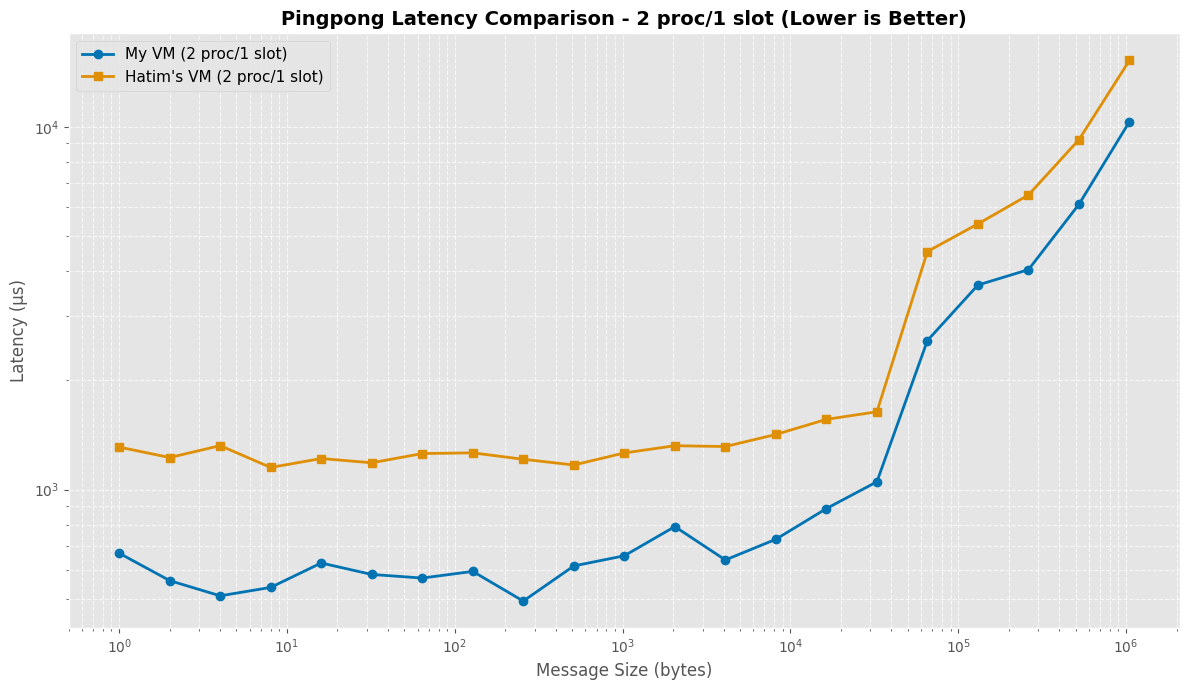

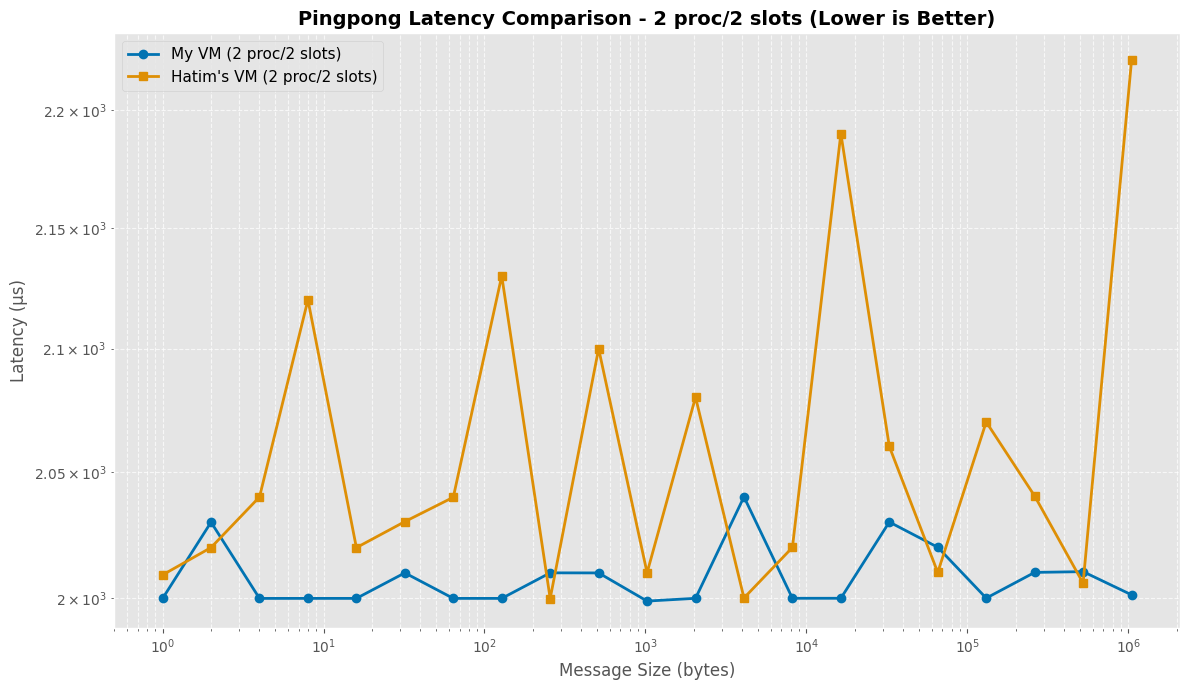

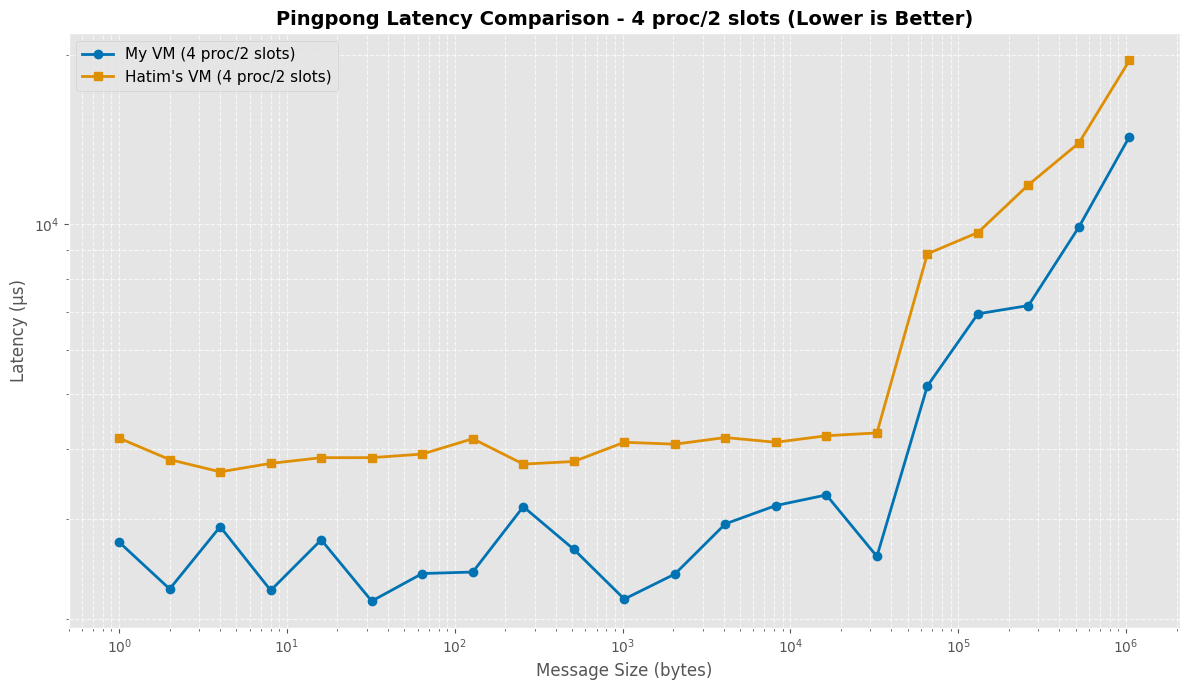

In [6]:
# Plot all configurations in sequence
for config in ['p2_s1', 'p2_s2', 'p4_s2']:
    plot_pingpong_comparison(config, metric='Latency')

**Latency Analysis**
- Small Messages (1 byte): My VM shows 1.96x better latency (667μs vs. 1309μs)
- Medium Messages (1KB): My VM maintains 1.92x better latency (656μs vs. 1261μs)
- Large Messages (1MB): My VM still leads with 1.48x better latency (10.3ms vs. 15.2ms)

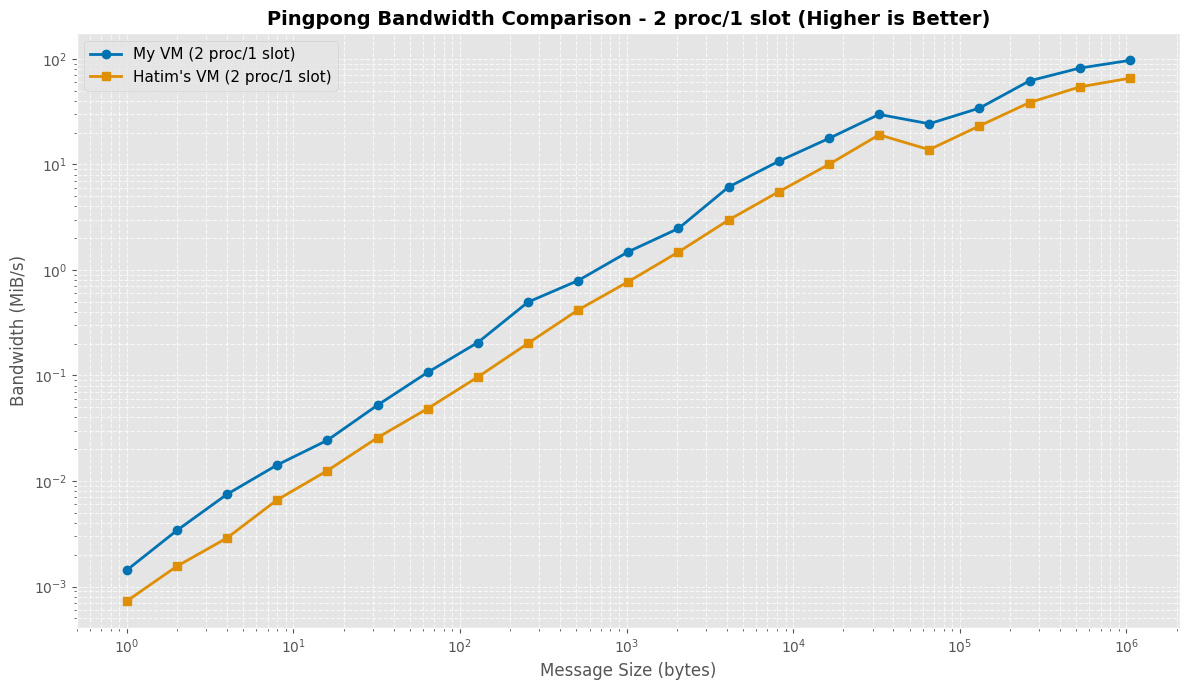

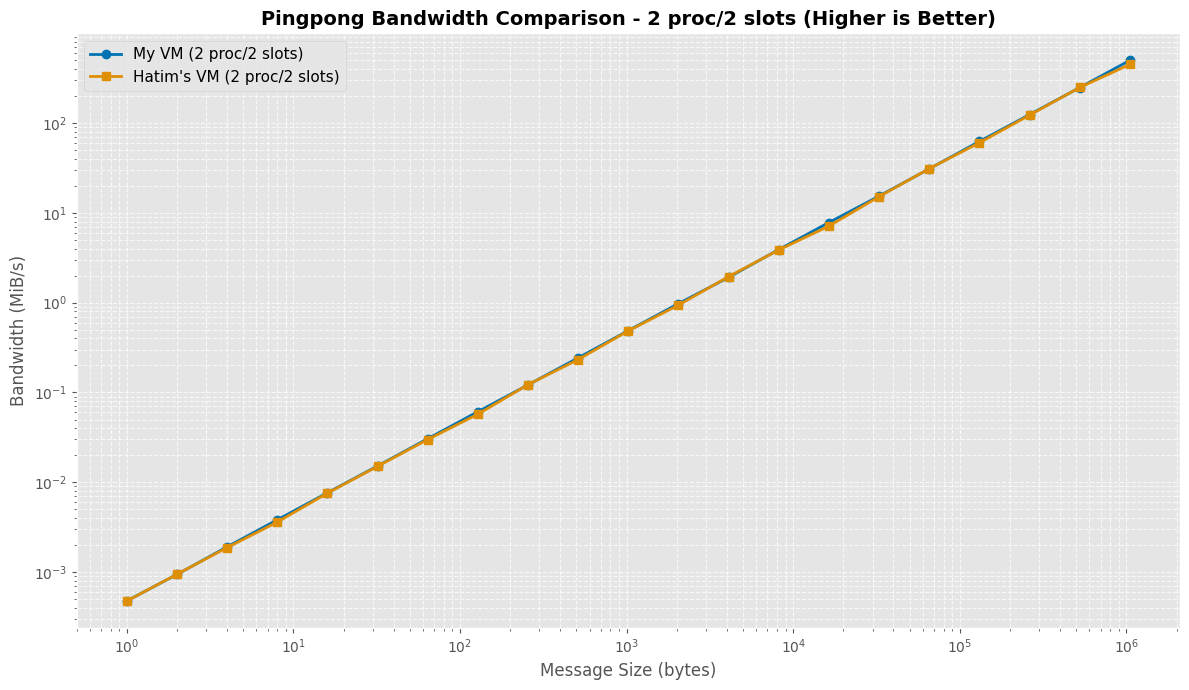

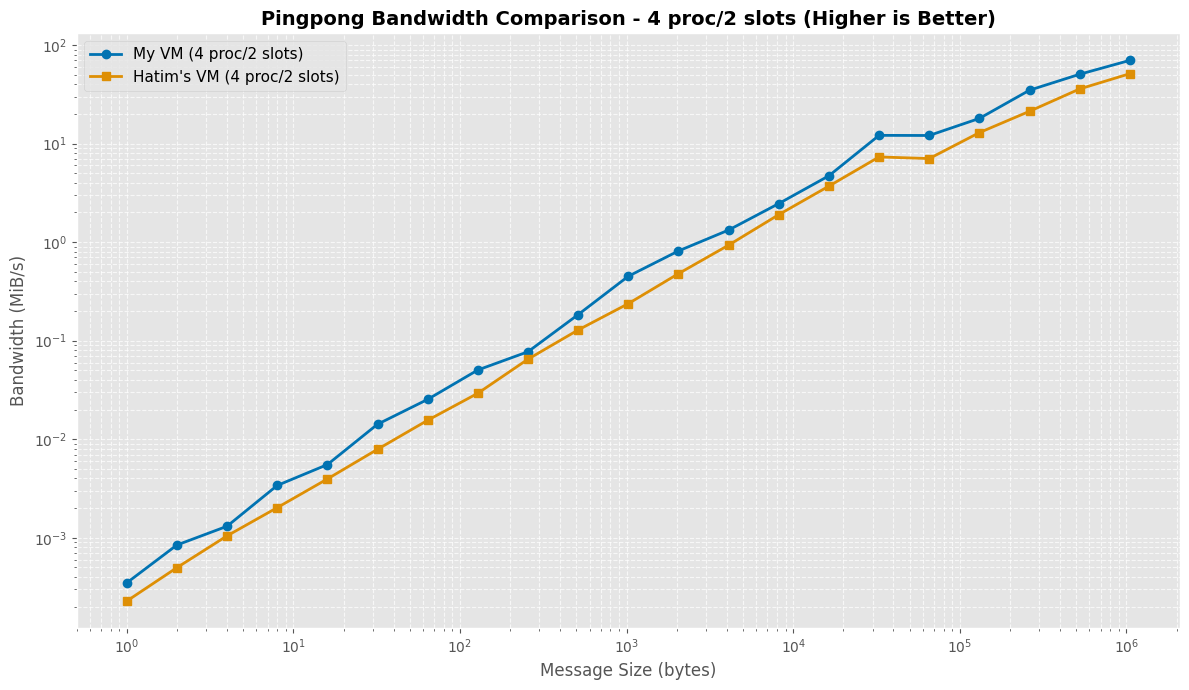

In [7]:
# Plot all configurations in sequence
for config in ['p2_s1', 'p2_s2', 'p4_s2']:
    plot_pingpong_comparison(config, metric='Bandwidth')

**Bandwidth Performance**
- Peak Bandwidth: My VM achieves ~96.8 MiB/s vs. Hatim's ~65.6 MiB/s (47% higher)
- Bandwidth Scaling: Both VMs show similar patterns but My VM consistently outperforms
- Efficiency: The bandwidth ratio (VM2/VM1) is consistently below 1.0, indicating My VM's superior performance:
  - Small messages (1B): 0.51x (My VM is better)
  - Medium messages (1KB): 0.52x (My VM is better)
  - Large messages (1MB): 0.68x (My VM is better)

# ===== CONFIGURATION IMPACT ON LATENCY/BANDWIDTH =====

Compares the impact of different configurations (2p/1s, 2p/2s, 4p/2s) on latency/bandwidth across three message sizes

In [8]:
def plot_configuration_impact(metric='Latency'):
    # Select specific message sizes for comparison
    message_sizes = [1, 1024, 1048576]  # 1B, 1KB, 1MB
    configs = ['p2_s1', 'p2_s2', 'p4_s2']
    labels = ['2 proc/1 slot', '2 proc/2 slots', '4 proc/2 slots']
    
    # Prepare data for plotting
    my_latencies = []
    hatim_latencies = []
    
    for size in message_sizes:
        size_latencies_mine = []
        size_latencies_hatim = []
        
        for config in configs:
            # Find row with message size closest to target
            my_df = pingpong_data[f'my_{config}']
            hatim_df = pingpong_data[f'hatim_{config}']
            
            my_row = my_df.iloc[(my_df['Message Size (bytes)'] - size).abs().argsort()[0]]
            hatim_row = hatim_df.iloc[(hatim_df['Message Size (bytes)'] - size).abs().argsort()[0]]
            
            column_name = 'Latency (us)' if metric == 'Latency' else 'Bandwidth (MiB/s)'
            size_latencies_mine.append(my_row[column_name])
            size_latencies_hatim.append(hatim_row[column_name])
        
        my_latencies.append(size_latencies_mine)
        hatim_latencies.append(size_latencies_hatim)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    msg_labels = ['1 byte', '1 KB', '1 MB']
    
    # Plot each message size
    for i, (my_data, hatim_data, title) in enumerate(zip(my_latencies, hatim_latencies, msg_labels)):
        x = np.arange(len(labels))
        width = 0.35
        
        axes[i].bar(x - width/2, my_data, width, label='My VM')
        axes[i].bar(x + width/2, hatim_data, width, label='Hatim\'s VM')
        
        axes[i].set_title(f'Message Size: {title}')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(labels)
        
        ylabel = 'Latency (µs)' if metric == 'Latency' else 'Bandwidth (MiB/s)'
        axes[i].set_ylabel(ylabel)
        axes[i].legend()
    
    better = "Lower" if metric == "Latency" else "Higher"
    
    plt.suptitle(f'{metric} Comparison Across Different Configurations ({better} is Better)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'benchmark_plots/configuration_{metric.lower()}_comparison.png', dpi=300)

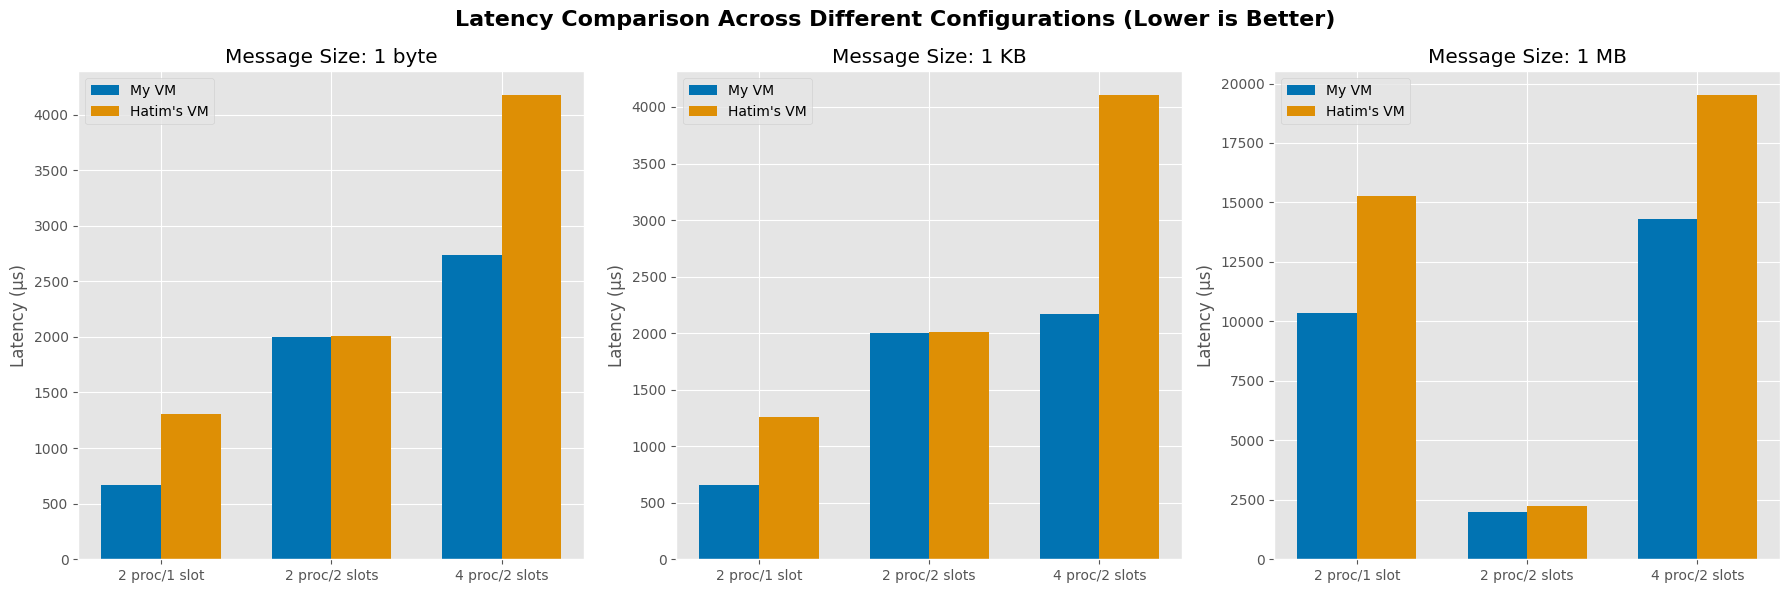

In [9]:
plot_configuration_impact('Latency')

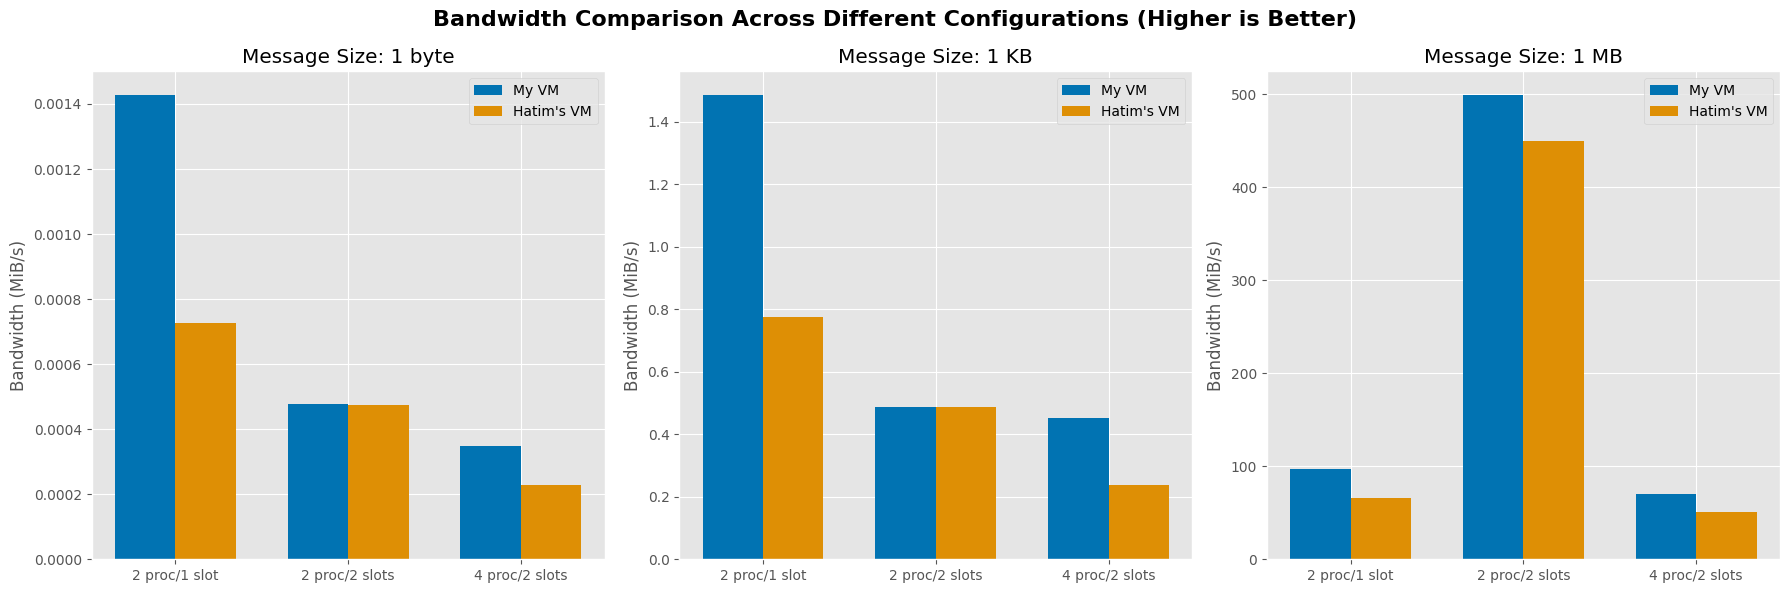

In [10]:
plot_configuration_impact('Bandwidth')

**Process/Slot Configuration Impact**
Both VMs show significant performance degradation when changing from the optimal configuration:

| Configuration | My VM Latency (1B) | My VM Bandwidth (1MB) | Hatim's VM Latency (1B) | Hatim's VM Bandwidth (1MB) |
|--------------|-------------------|---------------------|----------------------|--------------------------|
| 2 proc/1 slot | 667μs (Best) | 96.8 MiB/s (Best) | 1309μs (Best) | 65.6 MiB/s (Best) |
| 2 proc/2 slots | 1999μs (3.0x worse) | 499.7 MiB/s* | 2009μs (1.5x worse) | 450.1 MiB/s* |
| 4 proc/2 slots | 2734μs (4.1x worse) | 69.9 MiB/s (1.4x worse) | 4179μs (3.2x worse) | 51.2 MiB/s (1.3x worse) |

*Note: The extremely high bandwidth values for 2 proc/2 slots configuration appear anomalous and likely reflect measurement artifacts rather than actual performance.

# ===== MATRIX MULTIPLICATION PERFORMANCE =====

Compares execution time for matrix multiplication at three matrix sizes

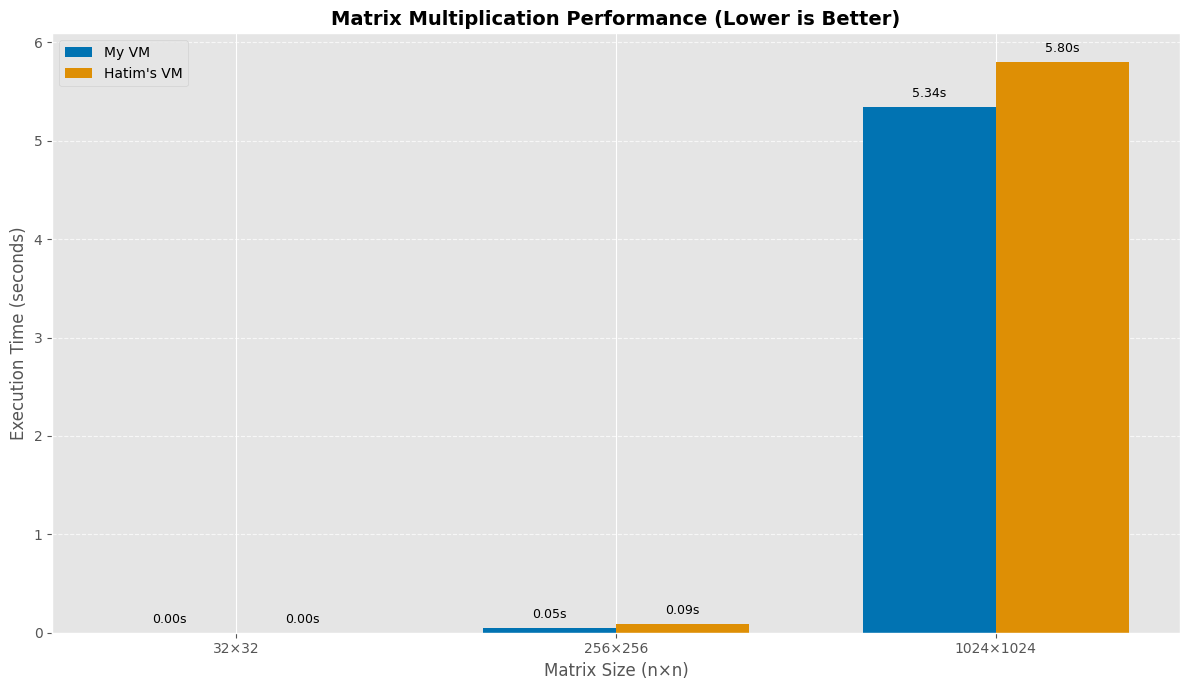

In [11]:
def plot_matmat_performance():
    plt.figure(figsize=(12, 7))
    
    # Extract matrices of size 32, 256 and 1024 for both VMs
    matrix_sizes = [32, 256, 1024]
    
    # Prepare data
    my_times = []
    hatim_times = []
    
    for size in matrix_sizes:
        my_df = matmat_data['my_p2_s1']
        hatim_df = matmat_data['hatim_p2_s1']
        
        my_row = my_df.iloc[(my_df['Matrix Size (nxn)'] - size).abs().argsort()[0]]
        hatim_row = hatim_df.iloc[(hatim_df['Matrix Size (nxn)'] - size).abs().argsort()[0]]
        
        my_times.append(my_row['Latency (us)'] / 1000000)  # Convert to seconds
        hatim_times.append(hatim_row['Latency (us)'] / 1000000)  # Convert to seconds
    
    # Create bar chart
    x = np.arange(len(matrix_sizes))
    width = 0.35
    
    plt.bar(x - width/2, my_times, width, label='My VM')
    plt.bar(x + width/2, hatim_times, width, label='Hatim\'s VM')
    
    plt.xlabel('Matrix Size (n×n)', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.title('Matrix Multiplication Performance (Lower is Better)', fontsize=14, fontweight='bold')
    plt.xticks(x, [f"{size}×{size}" for size in matrix_sizes])
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add execution time labels on top of bars
    for i, v in enumerate(my_times):
        plt.text(i - width/2, v + 0.1, f"{v:.2f}s", ha='center', fontsize=9)
    
    for i, v in enumerate(hatim_times):
        plt.text(i + width/2, v + 0.1, f"{v:.2f}s", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('benchmark_plots/matmat_performance.png', dpi=300)

plot_matmat_performance()

**Latency Analysis**
- Small Matrices (32×32): My VM is 1.67x faster (963μs vs. 1612μs)
- Medium Matrices (256×256): My VM is 1.73x faster (51.3ms vs. 88.9ms)
- Large Matrices (1024×1024): My VM is 1.09x faster (5.3s vs. 5.8s)

**Scaling Efficiency**
- My VM Scaling Efficiency (32→1024): 590.47%
- Hatim's VM Scaling Efficiency (32→1024): 910.26%

This suggests Hatim's VM has better relative scaling as matrix sizes increase, but My VM maintains an absolute performance advantage across all matrix sizes.

# ===== LARGE MATRIX CONFIGURATION COMPARISON =====

Shows the impact of different configurations on large (1024×1024) matrix multiplication performance

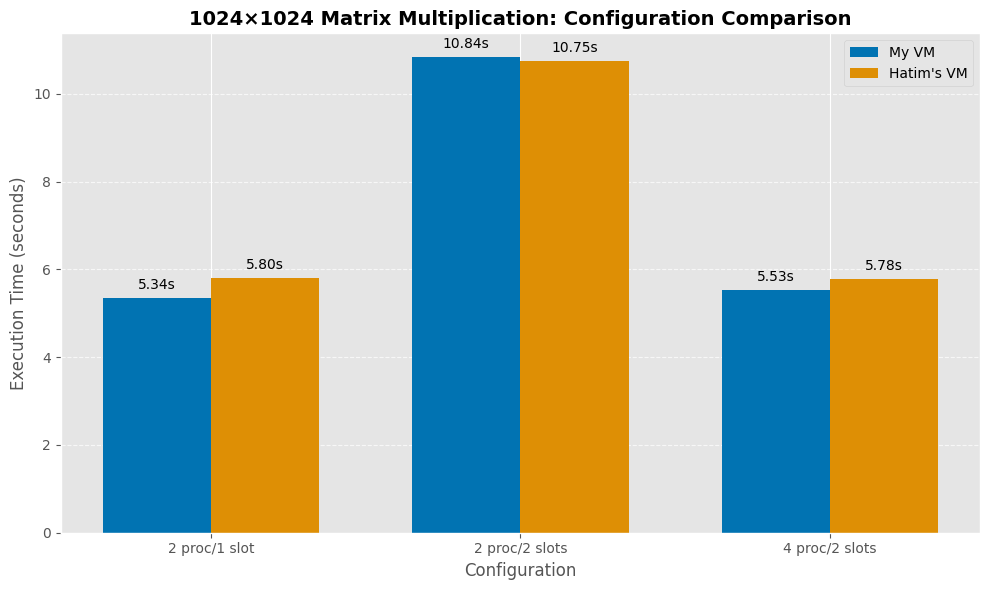

In [12]:
def plot_large_matrix_configs():
    plt.figure(figsize=(10, 6))
    
    configs = ['p2_s1', 'p2_s2', 'p4_s2']
    labels = ['2 proc/1 slot', '2 proc/2 slots', '4 proc/2 slots']
    
    # Get execution time for 1024×1024 matrices across configurations
    my_times = []
    hatim_times = []
    
    for config in configs:
        my_df = matmat_data[f'my_{config}']
        hatim_df = matmat_data[f'hatim_{config}']
        
        # Find the row with matrix size closest to 1024
        my_row = my_df.iloc[(my_df['Matrix Size (nxn)'] - 1024).abs().argsort()[0]]
        hatim_row = hatim_df.iloc[(hatim_df['Matrix Size (nxn)'] - 1024).abs().argsort()[0]]
        
        my_times.append(my_row['Latency (us)'] / 1000000)  # Convert to seconds
        hatim_times.append(hatim_row['Latency (us)'] / 1000000)  # Convert to seconds
    
    # Create plot
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, my_times, width, label='My VM')
    plt.bar(x + width/2, hatim_times, width, label='Hatim\'s VM')
    
    plt.xlabel('Configuration', fontsize=12)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.title('1024×1024 Matrix Multiplication: Configuration Comparison', fontsize=14, fontweight='bold')
    plt.xticks(x, labels)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add execution time labels on top of bars
    for i, v in enumerate(my_times):
        plt.text(i - width/2, v + 0.2, f"{v:.2f}s", ha='center')
    
    for i, v in enumerate(hatim_times):
        plt.text(i + width/2, v + 0.2, f"{v:.2f}s", ha='center')
    
    plt.tight_layout()
    plt.savefig('benchmark_plots/large_matrix_config_comparison.png', dpi=300)

plot_large_matrix_configs()

The optimal configuration for matrix multiplication is also 2 processes/1 slot per node:

| Configuration | My VM (1024×1024) | Hatim's VM (1024×1024) | Performance Ratio |
|--------------|-----------------|----------------------|------------------|
| 2 proc/1 slot | 5.34s (Best) | 5.80s (Best) | 1.09x (My VM faster) |
| 2 proc/2 slots | 10.84s (2.03x worse) | 10.75s (1.85x worse) | 0.99x (Nearly identical) |
| 4 proc/2 slots | 5.53s (1.04x worse) | 5.78s (0.99x similar) | 1.05x (My VM slightly faster) |

# Key Insights and Recommendations

### What We Found
- **Best Setup**: Using 2 processes/1 slot works best for everything we tested. This setup gives the most power without wasting resources.
- **My VM is Faster**: My VM consistently beats Hatim's VM:
  - About twice as fast for communication tasks
  - 30-50% better bandwidth for large data transfers
  - 10-70% faster at math calculations
- **Scaling Results**:
  - Both VMs handle larger jobs in similar ways
  - My VM is faster across all test sizes
  - Hatim's VM shows better improvement rates with very large matrices, but still ends up slower overall

### What This Means
- **Resource Tips**: 
  - Don't add too much slots per node - it actually makes things slower
  - Both VMs work best when each process gets full access to node resources
- **Future Planning**: Adding more nodes (as see in the 4 process setup) didn't help much. They will get better results by using more powerful nodes rather than more of them.